### Практическое задание к уроку 6
**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

os.environ['MKL_NUM_THREADS'] = '1'

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [2]:
data = pd.read_csv('./data/retail_train.csv')
item_features = pd.read_csv('./data/product.csv')
user_features = pd.read_csv('./data/hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [8]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [9]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [10]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\AVasilev\Jupyter Notebook\Recommendations-systems\utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [11]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (90504, 13) Users: 2375 Items: 5001
val_matcher
Shape: (168875, 12) Users: 2104 Items: 27584
train_ranker
Shape: (168875, 12) Users: 2104 Items: 27584
val_ranker
Shape: (117403, 12) Users: 1996 Items: 24270


# Grid search

In [12]:
from itertools import product

In [13]:
# N = Neighbors
N_PREDICT = 50 

In [14]:
weightings_list = ['bm25', 'tfidf']
model_type_list = ['als', 'bpr']
own_recommender_type_list = ['item-item', 'cosine', 'tfidf']
recs_type_list = ['own', 'rec', 'itm', 'usr']

In [19]:
result_dict = {
    'weighting': [],
    'model_type': [],
    'own_recommender_type': [],
    'own_recall': [],
    'rec_recall': [],
    'itm_recall': [],
    'usr_recall': []
}

In [21]:
%%time
for weighting, model_type, own_recommender in product(
            weightings_list, model_type_list, own_recommender_type_list):
    recommender = MainRecommender(data_train_matcher, weighting=weighting,
                                 model_type=model_type, own_recommender_type=own_recommender)
    result_dict['weighting'].append(weighting)
    result_dict['model_type'].append(model_type)
    result_dict['own_recommender_type'].append(own_recommender)
    
    for el in recs_type_list:
        res = recommender.evalMetrics(metric_type='recall', df_result=data_val_matcher, 
                        target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=N_PREDICT)
        result_dict[el + '_recall'].append(res)


Wall time: 10min 13s


In [23]:
result_df = pd.DataFrame(result_dict)
result_df

,weighting,model_type,own_recommender_type,own_recall,rec_recall,itm_recall,usr_recall
0,bm25,als,item-item,0.017500,0.010045,0.010247,0.002797
1,bm25,als,cosine,0.020191,0.009629,0.010196,0.002772
2,bm25,als,tfidf,0.020199,0.009455,0.010335,0.002964
3,bm25,bpr,item-item,0.017500,0.004118,0.006623,0.000622
4,bm25,bpr,cosine,0.020191,0.006043,0.006644,0.001280
5,bm25,bpr,tfidf,0.020199,0.004884,0.006606,0.001263
6,tfidf,als,item-item,0.010107,0.014955,0.008996,0.000458
7,tfidf,als,cosine,0.020742,0.014340,0.008853,0.006569
8,tfidf,als,tfidf,0.020726,0.014862,0.009048,0.006711
9,tfidf,bpr,item-item,0.010107,0.005196,0.006711,0.000446


In [30]:
for col in result_df.columns.to_list()[3:]:
    print(f'Best {col}:\n{result_df.loc[np.argmax(result_df[col]), :]}')
    print('*' * 30)

Best own_recall:
weighting                    tfidf
model_type                     als
own_recommender_type        cosine
own_recall               0.0207415
rec_recall               0.0143397
itm_recall              0.00885303
usr_recall              0.00656861
Name: 7, dtype: object
******************************
Best rec_recall:
weighting                     tfidf
model_type                      als
own_recommender_type      item-item
own_recall                0.0101069
rec_recall                0.0149549
itm_recall               0.00899584
usr_recall              0.000458271
Name: 6, dtype: object
******************************
Best itm_recall:
weighting                     bm25
model_type                     als
own_recommender_type         tfidf
own_recall               0.0201986
rec_recall              0.00945509
itm_recall               0.0103354
usr_recall              0.00296396
Name: 2, dtype: object
******************************
Best usr_recall:
weighting                   

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
**Наибольший recall@k показал метод get_own_recommendations=0.0207415  
Рекомендательная модель CosineRecommender(K=1). К матрице user_item_matrix применено взвешивание tf-idf**

# Init/train recommender

In [15]:
best_recommender = MainRecommender(data_train_matcher, weighting='tfidf',
                                 model_type='als', own_recommender_type='cosine')

### Recall@50 of matching

In [16]:
TOPK_RECALL = 50

In [17]:
for el in recs_type_list:
    res = best_recommender.evalMetrics(metric_type='recall', df_result=data_val_matcher, 
                    target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=TOPK_RECALL)
    print(f'{el} recall: {res}')

own recall: 0.020741546016824826
rec recall: 0.014707462904683808
itm recall: 0.008848822980527514
usr recall: 0.006611175050534427


### Precision@5 of matching

In [18]:
TOPK_PRECISION = 5

In [19]:
for el in recs_type_list:
    res = best_recommender.evalMetrics(metric_type='precision', df_result=data_val_matcher, 
                    target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=TOPK_PRECISION)
    print(f'{el} precision: {res}')

own precision: 0.10941064638783209
rec precision: 0.051615969581749424
itm precision: 0.018821292775665396
usr precision: 0.022433460076045682


# Изменяю k

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [22]:
k_list = [20, 50, 100, 200, 500]

In [21]:
recall_k_dict = {
    'k': [],
    'own': [],
    'rec': [],
    'itm': [],
    'usr': []
}

In [23]:
for k in k_list:
    recall_k_dict['k'].append(k)
    print(f'k={k}\n')
    for el in recs_type_list:
        res = best_recommender.evalMetrics(metric_type='recall', df_result=data_val_matcher, 
                        target_col_name=USER_COL, recommend_model_type=el, N_PREDICT=k)
        recall_k_dict[el].append(res)
        print(f'{el} recall: {res}')
    print('*' * 40)

k=20

own recall: 0.015273882525977238
rec recall: 0.009153479109011174
itm recall: 0.003872200684421867
usr recall: 0.004332170963247349
****************************************
k=50

own recall: 0.020741546016824826
rec recall: 0.014707462904683808
itm recall: 0.008848822980527514
usr recall: 0.006611175050534427
****************************************
k=100

own recall: 0.024909421205892988
rec recall: 0.0201862061870597
itm recall: 0.014123739346023132
usr recall: 0.008831202504297263
****************************************
k=200

own recall: 0.030233680660563686
rec recall: 0.026822205103634738
itm recall: 0.02167711775558721
usr recall: 0.011983158226319264
****************************************
k=500

own recall: 0.04015130103918654
rec recall: 0.03762816291343987
itm recall: 0.03403974846208189
usr recall: 0.01941555830101064
****************************************


In [26]:
recall_k_df = pd.DataFrame(recall_k_dict)

In [27]:
recall_k_df

,k,own,rec,itm,usr
0,20,0.015274,0.009153,0.003872,0.004332
1,50,0.020742,0.014707,0.008849,0.006611
2,100,0.024909,0.020186,0.014124,0.008831
3,200,0.030234,0.026822,0.021677,0.011983
4,500,0.040151,0.037628,0.034040,0.019416


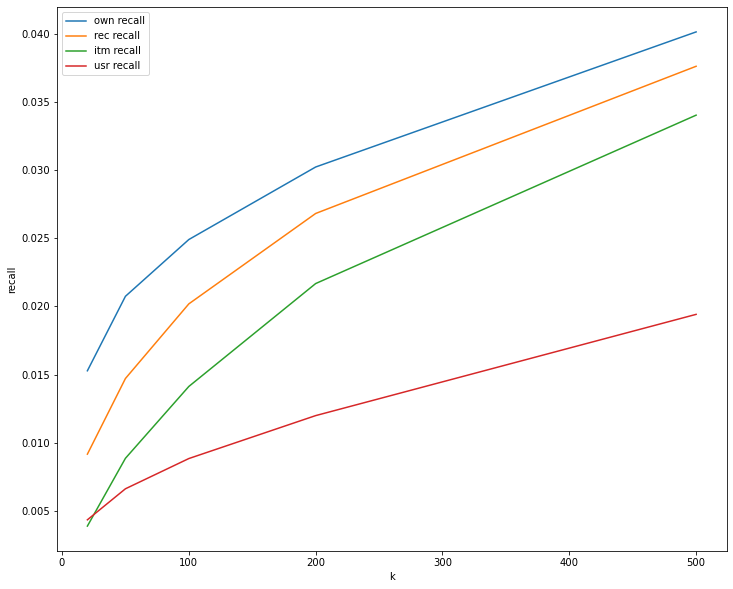

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

plt.plot(recall_k_df['k'], recall_k_df['own'], label='own recall')
plt.plot(recall_k_df['k'], recall_k_df['rec'], label='rec recall')
plt.plot(recall_k_df['k'], recall_k_df['itm'], label='itm recall')
plt.plot(recall_k_df['k'], recall_k_df['usr'], label='usr recall')

plt.xlabel('k')
plt.ylabel('recall')

plt.legend()
plt.show()

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?  

Однозначного ответа на данный вопрос дать нельзя. Выбор значения $k$ зависит от задачи, который стоит перед нами. При увеличении $k$ увеличивается $recall$, но при этом кратно увеличивается сложность вычисления.  
В данном случая, я думаю, $k$ нужно выбрать равным 100 или 200.

# Ranking part

## Подготовка данных для трейна

In [35]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [37]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: best_recommender.get_own_recommendations(x, N=N_PREDICT))

In [38]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[12810391, 12263816, 12988031, 1118963, 130728..."
1,2021,"[9245106, 895166, 909973, 12731685, 951761, 84..."


In [39]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [40]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [41]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,12810391
0,2070,12263816
0,2070,12988031
0,2070,1118963


### Check warm start

In [42]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (105200, 2) Users: 2104 Items: 4881


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [133]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [134]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [135]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [136]:
df_ranker_train.target.value_counts()

0.0    98941
1.0     3205
Name: target, dtype: int64

In [137]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,12810391,1.0
1,2070,12263816,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [138]:
df_ranker_train['target'].mean()

0.03137665694202416

## Подготавливаем фичи для обучения модели

In [139]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [140]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [141]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

**Фичи user_id:**  
    - Средний чек  
    - Средняя сумма покупки 1 товара в каждой категории  
    - Кол-во покупок в каждой категории  
    - Частотность покупок раз/месяц  
    - Долю покупок в выходные  
    - Долю покупок утром/днем/вечером  

**Фичи item_id**:  
    - Кол-во покупок в неделю  
    - Среднее кол-во покупок 1 товара в категории в неделю  
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)  
    - Цена (Можно посчитать из retil_train.csv)  
    - Цена / Средняя цена товара в категории  
    
**Фичи пары user_id - item_id**  
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)  
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)  
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)  

Средняя сумма покупки 1 товара в каждой категории

In [142]:
sales_value_by_department = data_train_ranker.merge(item_features, on='item_id', how='left').groupby(by='department')['sales_value'].sum().reset_index()
quantity_by_department = data_train_ranker.merge(item_features, on='item_id', how='left').groupby(by='department')['quantity'].sum().reset_index()
mean_purchase_by_department = sales_value_by_department.merge(quantity_by_department, on='department', how='left')
mean_purchase_by_department.drop(0, axis=0, inplace=True)
mean_purchase_by_department.reset_index(inplace=True)
mean_purchase_by_department.drop('index', axis=1, inplace=True)
mean_purchase_by_department['mean_purchase'] = mean_purchase_by_department['sales_value'] / mean_purchase_by_department['quantity']
mean_purchase_by_department.head()

,department,sales_value,quantity,mean_purchase
0,AUTOMOTIVE,5.39,1,5.390000
1,CHEF SHOPPE,181.64,69,2.632464
2,CNTRL/STORE SUP,9.00,9,1.000000
3,COSMETICS,2218.44,522,4.249885
4,COUP/STR & MFG,59.88,50,1.197600


In [143]:
df_ranker_train = df_ranker_train.merge(mean_purchase_by_department[['department', 'mean_purchase']], on='department', how='left')
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.921362
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.100465
2,2070,12988031,0.0,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.894526
3,2070,1118963,0.0,1156,DRUG GM,National,SHAVING CARE PRODUCTS,RAZORS AND BLADES,4 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.100465
4,2070,13072850,0.0,1091,DRUG GM,National,CHARCOAL AND LIGHTER FLUID,CHARCOAL,18 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.100465


In [104]:
data_train_ranker.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0


Кол-во покупок в каждой категории

In [146]:
num_purchases_by_department = data_train_ranker.merge(item_features, on='item_id', how='left').groupby(by='department')['basket_id'].nunique().reset_index()
num_purchases_by_department.rename(columns={'basket_id': 'num_purchases'}, inplace=True)
num_purchases_by_department.drop(0, axis=0, inplace=True)
num_purchases_by_department.reset_index(inplace=True)
num_purchases_by_department.drop('index', axis=1, inplace=True)
num_purchases_by_department.head()

,department,num_purchases
0,AUTOMOTIVE,1
1,CHEF SHOPPE,60
2,CNTRL/STORE SUP,8
3,COSMETICS,329
4,COUP/STR & MFG,37


In [148]:
df_ranker_train = df_ranker_train.merge(num_purchases_by_department[['department', 'num_purchases']], on='department', how='left')
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_purchase,num_purchases
0,2070,12810391,1.0,3452,MEAT,National,PORK,ENHANCED,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,4.921362,3365
1,2070,12263816,0.0,903,DRUG GM,Private,ANALGESICS,SINUS AND ALLERGY,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.100465,7713


### Разбиваю на X и y

In [ ]:
df_ranker_train.head()

In [ ]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [ ]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

## Обучение модели ранжирования

In [ ]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [ ]:
df_ranker_predict = df_ranker_train.copy()

In [ ]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [ ]:
df_ranker_predict.head()

## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [ ]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

## Eval matching on test dataset

In [ ]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [ ]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [ ]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [ ]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [ ]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера